In [1]:
import torch
from yolox.exp import get_exp
from yolox.utils import get_model_info

# Define your experiment/model configuration
# You need to specify which YOLOX variant you finetuned (s, m, l, x, nano, tiny)
exp = get_exp(exp_file=None, exp_name="yolox-lft")  # Replace with your variant

# Build the model
model = exp.get_model()

# Load the checkpoint
ckpt = torch.load("yolox_l_finetuned.pth", map_location="cpu")

# Handle different checkpoint formats
if "model" in ckpt:
    model.load_state_dict(ckpt["model"])
else:
    model.load_state_dict(ckpt)

# Set to evaluation mode
model.eval()

# Optional: Move to GPU
if torch.cuda.is_available():
    model = model.cuda()

# Print model info
model_info = get_model_info(model, exp.test_size)
print(f"Model Summary: {model_info}")

/var/folders/br/w32q7z3s33j_j8w7b42_dt6w0000gn/T/ipykernel_32083/528285473.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("yolox_l_finetuned.pth", ma

Model Summary: Params: 54.21M, Gflops: 156.02


In [2]:
from yolox.data.data_augment import ValTransform
from yolox.utils import postprocess
import cv2
import numpy as np

# Load and preprocess image
image = cv2.imread("val2017/0005.jpg")
height, width = image.shape[:2]

# Preprocess
preproc = ValTransform(legacy=False)
img, _ = preproc(image, None, exp.test_size)
img = torch.from_numpy(img).unsqueeze(0).float()

if torch.cuda.is_available():
    img = img.cuda()

# Inference
with torch.no_grad():
    outputs = model(img)
    outputs = postprocess(
        outputs, exp.num_classes, exp.test_conf, exp.nmsthre
    )[0]

# Process outputs
if outputs is not None:
    outputs[:, 0:4] /= min(exp.test_size[0] / height, exp.test_size[1] / width)
    # outputs contains: [x1, y1, x2, y2, obj_conf, class_conf, class_id]

In [3]:
outputs

tensor([[6.3459e+02, 1.1803e+02, 9.1126e+02, 6.1495e+02, 9.7548e-01, 9.7330e-01,
         8.0000e+01],
        [3.5957e+02, 1.0496e+02, 6.2193e+02, 6.3772e+02, 9.7132e-01, 9.7580e-01,
         8.0000e+01],
        [1.0245e+02, 1.9575e+02, 3.6798e+02, 6.3741e+02, 9.8407e-01, 9.6042e-01,
         8.0000e+01],
        [8.0743e+02, 8.5085e+01, 8.3642e+02, 1.3136e+02, 9.8340e-01, 8.9426e-01,
         0.0000e+00],
        [8.4110e+02, 1.6781e+01, 1.0238e+03, 5.0250e+02, 9.3588e-01, 9.3126e-01,
         2.0000e+00],
        [7.1099e+01, 8.2590e+01, 5.3988e+02, 2.6704e+02, 9.0591e-01, 8.5900e-01,
         2.0000e+00],
        [7.1990e+02, 5.5543e+00, 1.0209e+03, 4.9757e+02, 1.8802e-01, 8.6125e-01,
         2.0000e+00],
        [6.4450e+01, 8.8890e+01, 3.8620e+02, 2.6734e+02, 1.5658e-01, 8.7314e-01,
         2.0000e+00],
        [2.2111e+02, 8.9969e+01, 5.2531e+02, 2.2994e+02, 4.6070e-02, 7.7862e-01,
         2.0000e+00],
        [1.3188e+02, 9.1460e+01, 6.1522e+02, 6.0721e+02, 2.3209e-02, 8.07

In [4]:
from yolox.utils.visualize import vis

boxes = outputs[:, 0:4]
scores = outputs[:, 4] 
class_ids = outputs[:, 5]

class_names = [str(i+1) for i in range(80)]

img_with_bbox = vis(image, boxes=boxes, scores=scores, cls_ids=class_ids, class_names=class_names)


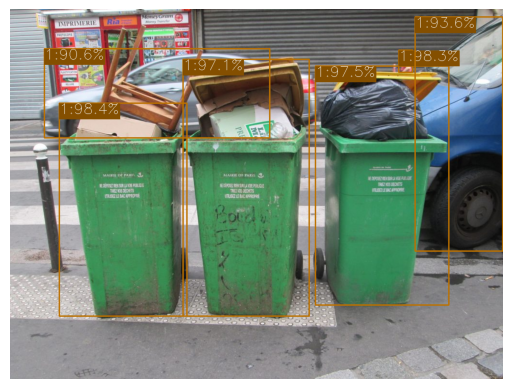

In [5]:
cv2.imshow("Detection Results", img_with_bbox)

# In a standard Jupyter environment, cv2.imshow() may not work as expected.
# A common way to display images is using matplotlib.
import matplotlib.pyplot as plt

# OpenCV loads images in BGR order, but matplotlib expects RGB.
# We need to convert the color space.
plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
plt.axis('off')  # Hide the axes
plt.show()

# If you are in an environment where cv2.imshow() works, you would typically follow it with:
# cv2.waitKey(0)
# cv2.destroyAllWindows()
# However, the matplotlib approach is more portable for notebooks.

In [6]:
COCO_CLASSES = (
    "person",
    "bicycle",
    "car",
    "motorcycle",
    "airplane",
    "bus",
    "train",
    "truck",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "horse",
    "sheep",
    "cow",
    "elephant",
    "bear",
    "zebra",
    "giraffe",
    "backpack",
    "umbrella",
    "handbag",
    "tie",
    "suitcase",
    "frisbee",
    "skis",
    "snowboard",
    "sports ball",
    "kite",
    "baseball bat",
    "baseball glove",
    "skateboard",
    "surfboard",
    "tennis racket",
    "bottle",
    "wine glass",
    "cup",
    "fork",
    "knife",
    "spoon",
    "bowl",
    "banana",
    "apple",
    "sandwich",
    "orange",
    "broccoli",
    "carrot",
    "hot dog",
    "pizza",
    "donut",
    "cake",
    "chair",
    "couch",
    "potted plant",
    "bed",
    "dining table",
    "toilet",
    "tv",
    "laptop",
    "mouse",
    "remote",
    "keyboard",
    "cell phone",
    "microwave",
    "oven",
    "toaster",
    "sink",
    "refrigerator",
    "book",
    "clock",
    "vase",
    "scissors",
    "teddy bear",
    "hair drier",
    "toothbrush",
    "trashcan"
)

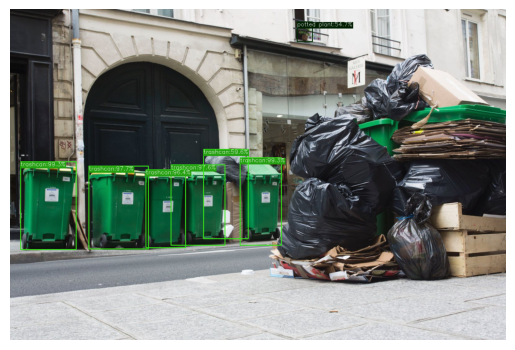

In [9]:
def show_image(image_path):
    image = cv2.imread(image_path)
    
    height, width = image.shape[:2]

    # Preprocess
    preproc = ValTransform(legacy=False)
    img, _ = preproc(image, None, exp.test_size)
    img = torch.from_numpy(img).unsqueeze(0).float()

    if torch.cuda.is_available():
        img = img.cuda()

    # Inference
    with torch.no_grad():
        outputs = model(img)
        outputs = postprocess(
            outputs, exp.num_classes, exp.test_conf, exp.nmsthre
        )[0]

    # Process outputs
    if outputs is not None:
        outputs[:, 0:4] /= min(exp.test_size[0] / height, exp.test_size[1] / width)
        # outputs contains: [x1, y1, x2, y2, obj_conf, class_conf, class_id]
        
    boxes = outputs[:, 0:4]
    scores = outputs[:, 4] 
    class_ids = outputs[:, 6]

    class_names = [str(i+1) for i in range(81)]
    class_names = COCO_CLASSES  

    img_with_bbox = vis(image, boxes=boxes, scores=scores, cls_ids=class_ids, class_names=class_names, fontScale=0.6)

    plt.imshow(cv2.cvtColor(img_with_bbox, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Hide the axes
    plt.show()
    
show_image("val2017/0008.jpg")